In [175]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [176]:
img = cv2.imread("./test_images/000020.jpg")
img.shape    # 3rd dimension is RGB value

(1802, 2400, 3)

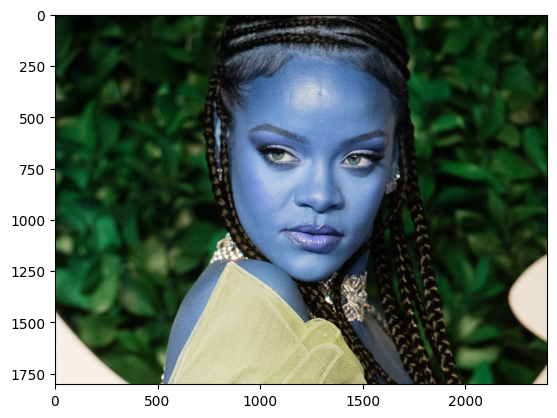

In [177]:
plt.imshow(img)

In [178]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape  #used to remove 3rd dimension

(1802, 2400)

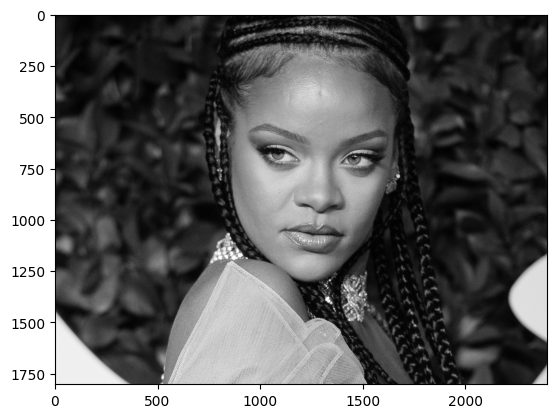

In [179]:
plt.imshow(gray, cmap='gray')

(1) Preprocessing: Detect face and eyes
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.

In [181]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# 1.3 - Specifies how much the image size is reduced at each image scale.
# 5 - Specifies how many neighbors each candidate rectangle should have to retain it.
faces

array([[798, 279, 977, 977]], dtype=int32)

In [182]:
(x, y, w, h) = faces[0]
x, y, w, h

(798, 279, 977, 977)

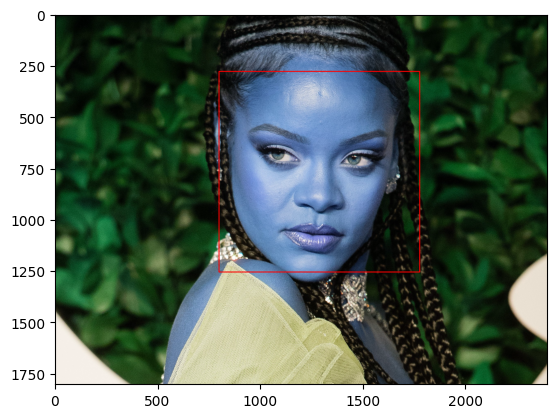

In [183]:
face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 3)
plt.imshow(face_img)

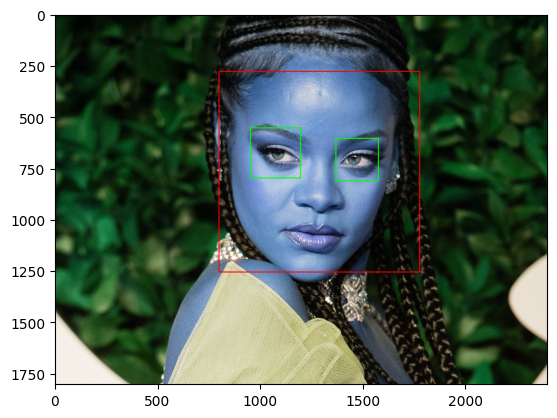

In [184]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 3)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 3)

plt.figure()
plt.imshow(face_img, cmap="gray")
plt.show()

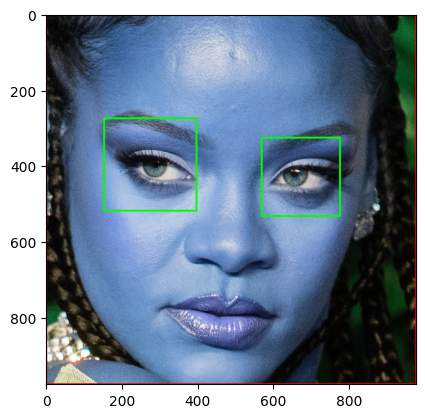

In [185]:
plt.imshow(roi_color, cmap="gray")

(2) Preprocessing: Crop the facial region of the image

In [194]:
def get_cropped_images_if_2_eyes_visible(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x, y, w, h) in faces:
            roi_color = img[y:y+h, x:x+w]
            roi_gray = gray[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color
        


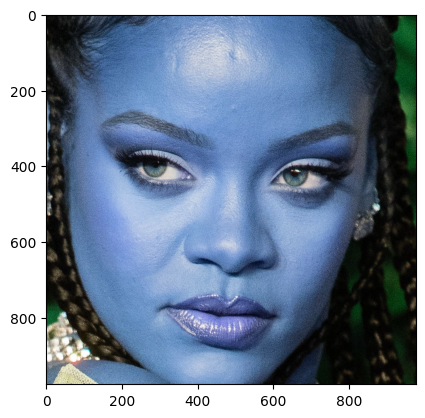

In [187]:
cropped_image = get_cropped_images_if_2_eyes_visible("./test_images/000020.jpg")
plt.imshow(cropped_image)

In [188]:
path_to_data = "./dataset"
path_to_cropped = "./dataset/cropped/"


In [189]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
       img_dirs.append(entry.path)

In [190]:
img_dirs

['./dataset/Greta_Thunberg',
 './dataset/Mark_Ruffalo',
 './dataset/Rihanna',
 './dataset/MS_Dhoni_2',
 './dataset/cropped',
 './dataset/Tom_Hiddleston']

In [196]:
import shutil
if os.path.exists(path_to_cropped):
    shutil.rmtree(path_to_cropped)
os.mkdir(path_to_cropped)

Run this to get cropped images for the very first time.

In [197]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)

    for entry in os.scandir(img_dir):
        roi_color = get_cropped_images_if_2_eyes_visible(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cropped + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                print("Generating cropped images in folder", cropped_folder)

            
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict.setdefault(celebrity_name, []).append(cropped_file_path)
            count += 1

Greta_Thunberg
Generating cropped images in folder ./dataset/cropped/Greta_Thunberg
Mark_Ruffalo
Generating cropped images in folder ./dataset/cropped/Mark_Ruffalo
Rihanna
Generating cropped images in folder ./dataset/cropped/Rihanna
MS_Dhoni_2
Generating cropped images in folder ./dataset/cropped/MS_Dhoni_2
cropped
Tom_Hiddleston
Generating cropped images in folder ./dataset/cropped/Tom_Hiddleston


run this if u already have cropped folder and manually cleaned the unwanted data

In [ ]:
# import os
# cropped_dir = []
# for entry in os.scandir('./dataset/cropped'):
#     if entry.is_dir():
#        cropped_dir.append(entry.path)

In [ ]:
# cropped_dir

In [ ]:
# celebrity_file_names_dict = {}

# for folder in cropped_dir:
#     celebrity_name = folder.split('/')[-1]
#     # print(celebrity_name)

#     for entry in os.scandir(folder):
#         celebrity_file_names_dict.setdefault(celebrity_name, []).append(entry.path)
        

In [ ]:
# celebrity_file_names_dict

(3) Preprocessing: Use wavelet transform as a feature for traning our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc

In [198]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_BGR2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

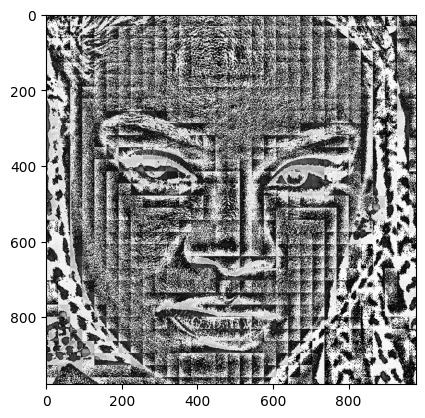

In [199]:
im_har = w2d(cropped_image, 'db1', 5)
plt.imshow(im_har, cmap="gray")

In [200]:
celebrity_file_names_dict

{'Greta_Thunberg': ['./dataset/cropped/Greta_Thunberg/Greta_Thunberg1.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg2.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg3.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg4.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg5.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg6.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg7.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg8.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg9.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg10.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg11.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg12.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg13.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg14.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg15.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunberg16.png',
  './dataset/cropped/Greta_Thunberg/Greta_Thunb

In [201]:
class_dict={}
count=0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'Greta_Thunberg': 0,
 'Mark_Ruffalo': 1,
 'Rihanna': 2,
 'MS_Dhoni_2': 3,
 'Tom_Hiddleston': 4}

In [202]:
X = []
y = []


In [203]:

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        # print(training_image)
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_img =cv2.resize(img, (32,32))
        img_har = w2d(img, 'db1', 5)
        scaled_img_har = cv2.resize(img_har, (32,32))
        combined_img = np.vstack((scaled_raw_img.reshape(32*32*3, 1), scaled_img_har.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])


[ WARN:0@14595.044] global loadsave.cpp:248 findDecoder imread_('./dataset/cropped/Mark_Ruffalo/Mark_Ruffalo2.png'): can't open/read file: check file path/integrity
[ WARN:0@14595.741] global loadsave.cpp:248 findDecoder imread_('./dataset/cropped/Mark_Ruffalo/Mark_Ruffalo12.png'): can't open/read file: check file path/integrity
[ WARN:0@14596.097] global loadsave.cpp:248 findDecoder imread_('./dataset/cropped/Mark_Ruffalo/Mark_Ruffalo22.png'): can't open/read file: check file path/integrity
[ WARN:0@14596.098] global loadsave.cpp:248 findDecoder imread_('./dataset/cropped/Mark_Ruffalo/Mark_Ruffalo23.png'): can't open/read file: check file path/integrity
[ WARN:0@14600.233] global loadsave.cpp:248 findDecoder imread_('./dataset/cropped/Rihanna/Rihanna24.png'): can't open/read file: check file path/integrity
[ WARN:0@14601.255] global loadsave.cpp:248 findDecoder imread_('./dataset/cropped/MS_Dhoni_2/MS_Dhoni_23.png'): can't open/read file: check file path/integrity
[ WARN:0@14601.645] 

In [ ]:
32*32*3 + 32*32

In [204]:
len(X[0])

4096

In [205]:
X[0]

array([[ 57],
       [ 73],
       [ 80],
       ...,
       [  5],
       [251],
       [252]], dtype=uint8)

In [206]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X.shape

(219, 4096)

In [207]:
X[0]

array([ 57.,  73.,  80., ...,   5., 251., 252.])

SVM Model

In [208]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
# from imblearn.over_sampling import SMOTE


In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 2. Apply SMOTE only on the training data
# sm = SMOTE(random_state=42)
# X_train_resampled, y_train = sm.fit_resample(X_train, y_train)
pipe = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7272727272727273

In [210]:
len(X_test)

55

In [211]:
print(classification_report(y_true= y_test, y_pred=pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.67      0.67      0.67         9
           2       0.69      1.00      0.82         9
           3       0.83      0.88      0.86        17
           4       0.62      0.50      0.56        10

    accuracy                           0.73        55
   macro avg       0.71      0.71      0.70        55
weighted avg       0.72      0.73      0.72        55



Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters

In [230]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [231]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True, class_weight='balanced'),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [219]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.798106,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.591098,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.798864,{'logisticregression__C': 1}


These are the scores for validation test

In [220]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, class_weight='balanced', gamma='auto',
                      kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

These are the scores of test set

In [221]:
best_estimators['svm'].score(X_test,y_test)

0.7636363636363637

In [222]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7636363636363637

In [223]:
print(classification_report(y_true= y_test, y_pred=best_estimators['svm'].predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.69      1.00      0.82         9
           2       0.62      0.89      0.73         9
           3       0.94      0.94      0.94        17
           4       0.83      0.50      0.62        10

    accuracy                           0.76        55
   macro avg       0.75      0.75      0.72        55
weighted avg       0.78      0.76      0.75        55



In [225]:
best_clf = best_estimators['svm']

In [226]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 4,  1,  4,  0,  1],
       [ 0,  9,  0,  0,  0],
       [ 0,  1,  8,  0,  0],
       [ 0,  0,  1, 16,  0],
       [ 2,  2,  0,  1,  5]])

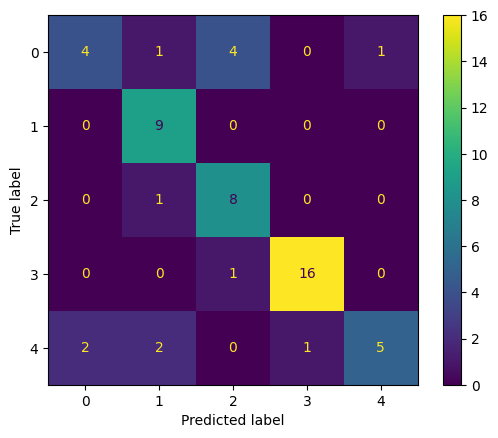

In [227]:
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [228]:
class_dict

{'Greta_Thunberg': 0,
 'Mark_Ruffalo': 1,
 'Rihanna': 2,
 'MS_Dhoni_2': 3,
 'Tom_Hiddleston': 4}

In [232]:
!pip install joblib
import joblib


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [233]:
joblib.dump(best_clf, 'saved_model_3.pkl')

['saved_model_3.pkl']

In [ ]:
import json
with open("class_dictionary", "w") as f:
    f.write(json.dumps(class_dict))